
# **Project Description**
Truy tìm hình ảnh khuôn mặt (FIR) là một nhiệm vụ trong thị giác máy tính, có thể được sử dụng để tìm kiếm các hình ảnh khuôn mặt tương tự hoặc truy vấn ra các đặc tính của khuôn mặt.

Để truy vấn ra các đặc tính của khuôn mặt, mô hình FIR cần được huấn luyện trên một tập dữ liệu lớn các hình ảnh khuôn mặt được gắn nhãn các đặc tính cần truy vấn. Mô hình sẽ học cách trích xuất các đặc điểm của khuôn mặt liên quan đến các đặc tính đó.

FIR với mục tiêu truy vấn ra các đặc tính của khuôn mặt có thể được ứng dụng trong nhiều lĩnh vực, chẳng hạn như xác nhận danh tính, tìm kiếm ảnh, quảng cáo, chăm sóc sức khỏe và giáo dục.

Một số ví dụ cụ thể về ứng dụng của FIR trong các lĩnh vực khác nhau:
*   Xác nhận danh tính: FIR có thể được sử dụng để xác định giới tính, độ tuổi của người trong ảnh. Thông tin này có thể được sử dụng để xác minh danh tính của người đó.
*   Tìm kiếm ảnh: FIR có thể được sử dụng để tìm kiếm các hình ảnh của người có giới tính, độ tuổi hoặc cảm xúc cụ thể.
*   Giáo dục: FIR có thể được sử dụng để cá nhân hóa việc học, chẳng hạn như cung cấp các tài liệu học tập phù hợp với trình độ của học sinh.
*   Chăm sóc sức khỏe: FIR có thể được sử dụng để theo dõi sức khỏe của bệnh nhân, chẳng hạn như theo dõi biểu hiện khuôn mặt để phát hiện các dấu hiệu của bệnh.
*   Quảng cáo: FIR có thể được sử dụng để nhắm mục tiêu quảng cáo đến các đối tượng cụ thể dựa trên giới tính, độ tuổi hoặc sở thích của họ.

**Với sự phát triển của các mô hình học sâu, FIR với mục tiêu này hứa hẹn sẽ trở nên chính xác và hiệu quả hơn trong tương lai.**
# **Team Members**
*Nhóm HNP*:

| Tên | MSSV | Đóng góp % | Ghi Chú |
|-------------|----------------|------------------------|------|
| Trần Minh Hiển | 21280016 | 100% | |
| Trần Ngọc Khánh Như | 21280040 | 100% |Nhóm trưởng |
| Lâm Gia Phú | 21280104 | 100% ||



# **1. Collecting and Preparing Data**

**Import libraries**

In [ ]:
# Thêm các thư viên cần thiết
import zipfile
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import f1_score,precision_score
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from pathlib import Path
import math
import copy
import gc
from tqdm import tqdm

from google.colab import drive


In [ ]:
#Tạo một thư mục "data_faces" và tải xuống tập dữ liệu CelebA ở định dạng ZIP vào thư mục đó
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-02-03 09:11:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.144, 52.219.113.88, 52.219.112.232, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  64.6MB/s    in 21s     

2024-02-03 09:11:34 (67.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
# Extract tệp ZIP ("celeba.zip") vào một thư mục cụ thể ("data_faces/")
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")
# In số lượng tệp hình ảnh có trong thư mục con ("img_align_celeba")
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
# Cấp quyền truy cập vào Google Drive thực hiện đọc và ghi tệp giữa Google Drive và môi trường Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Đọc dữ liệu từ file .txt vào DataFrame Pandas, bỏ qua hàng đầu tiên
df1 = pd.read_csv('/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt', sep="\s+", skiprows=1)
# Lưu DataFrame vào tệp CSV mới.
df1.to_csv('list_attr_celeba.csv', index = True)

In [ ]:
# Đọc Dataset
image_path='/content/data_faces/img_align_celeba'
df_attr=pd.read_csv('/content/list_attr_celeba.csv')

In [ ]:
# Đổi tên cột đầu tiên của DataFrame 'df_attr' thành 'image_id'
df_attr = df_attr.rename(columns={df_attr.columns[0]: "image_id"})

In [ ]:
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

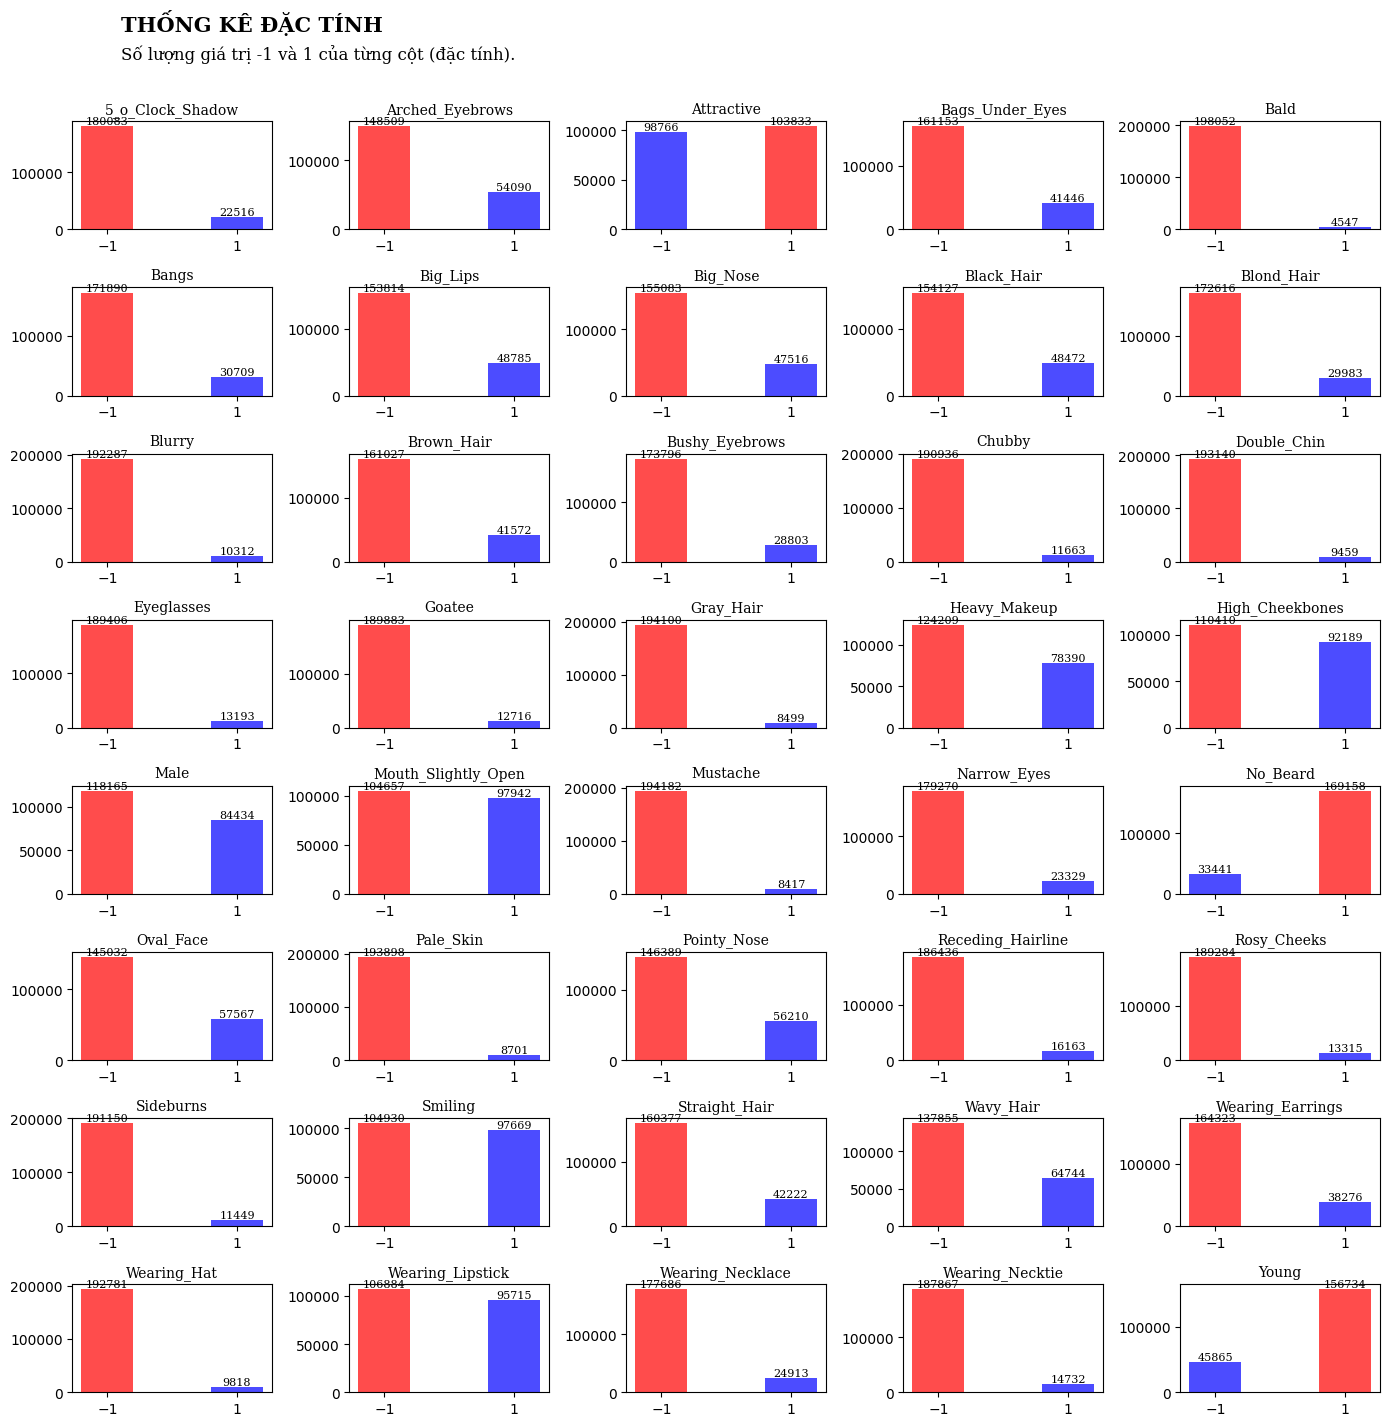

In [ ]:
df_vs = pd.DataFrame(df_attr.iloc[:, 1:])

# Vẽ 40 biểu đồ nhỏ
fig, axs = plt.subplots(8, 5, figsize=(14, 14))
fig.text(0.09, 1, 'THỐNG KÊ ĐẶC TÍNH', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.98, 'Số lượng giá trị -1 và 1 của từng cột (đặc tính).', fontsize=12, fontweight='light', fontfamily='serif')

for i in range(40):  # Use a single loop index
    row, col = divmod(i, 5)
    ax = axs[row, col]

    # Tính toán số lượng giá trị -1 và 1 trong cột cụ thể
    value_counts = df_vs.iloc[:, i].value_counts()

    # Vẽ biểu đồ
    bars = ax.bar(value_counts.index, value_counts.values, color=['red', 'blue'], alpha=0.7)
    ax.set_title(df_vs.columns[i], fontsize = 10, fontfamily='serif')
    ax.set_xticks([-1, 1])

    # Thêm text annotation vào mỗi thanh cột
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize = 8, fontfamily='serif')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

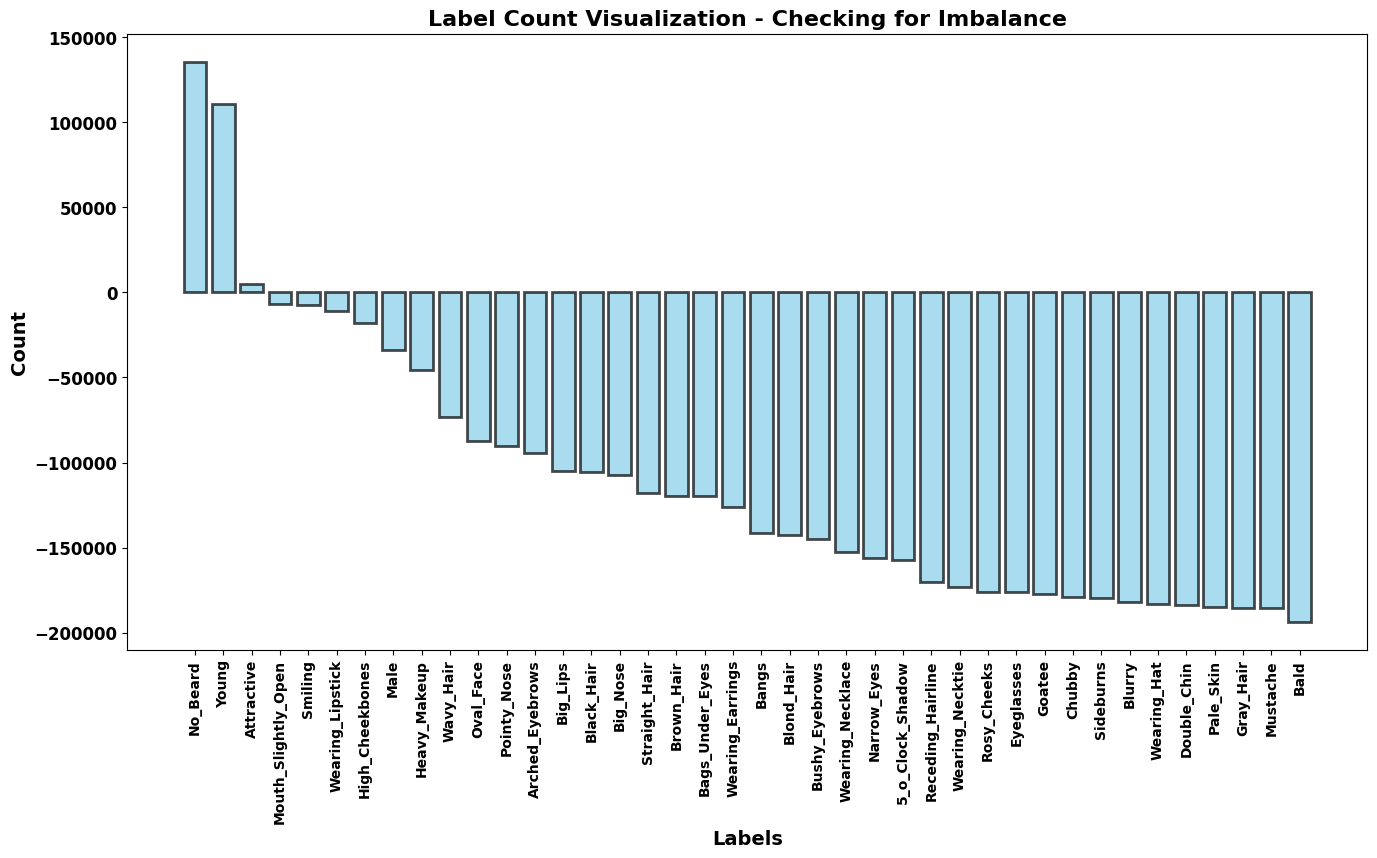

In [ ]:
# Trực quan hóa số lượng labels/ attributes của dataset và kiểm tra sự mất cân bằng.
import matplotlib.pyplot as plt

arr = pd.DataFrame(df_attr.iloc[:, 1:].sum(axis=0))
arr.columns = ['labels']
arr = arr.sort_values(by='labels', ascending=False)

plt.figure(figsize=(16, 8))
plt.bar(arr.index, arr['labels'], color='skyblue', edgecolor='black', linestyle='-', linewidth=2, alpha=0.7)
plt.xticks(arr.index, rotation=90, fontweight='bold', fontsize=10)
plt.yticks(fontweight='bold', fontsize=12)
plt.title('Label Count Visualization - Checking for Imbalance', fontsize=16, fontweight='bold')
plt.xlabel('Labels', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.show()

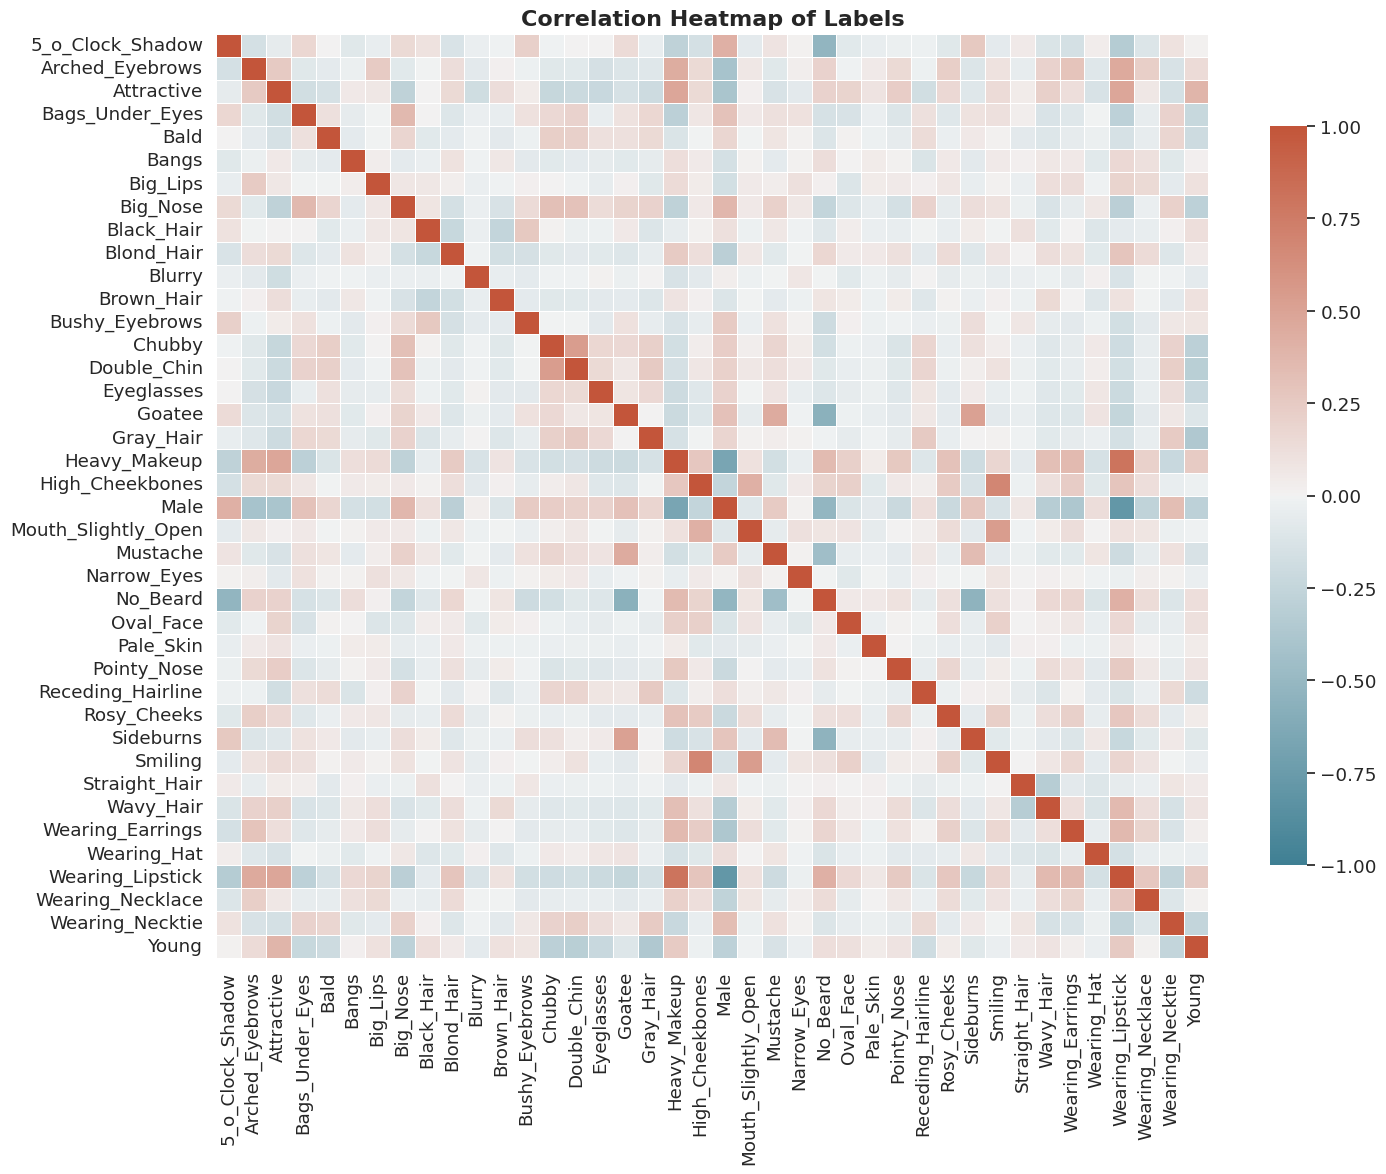

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df_attr.iloc[:, 1:].corr(), cmap=cmap, vmin=-1, vmax=1, annot=False, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Labels', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Thay các giá trị -1 thành 0. Đưa về bài toán phân loại nhị phân (binary classification)
df_attr.replace(-1,0,inplace=True)

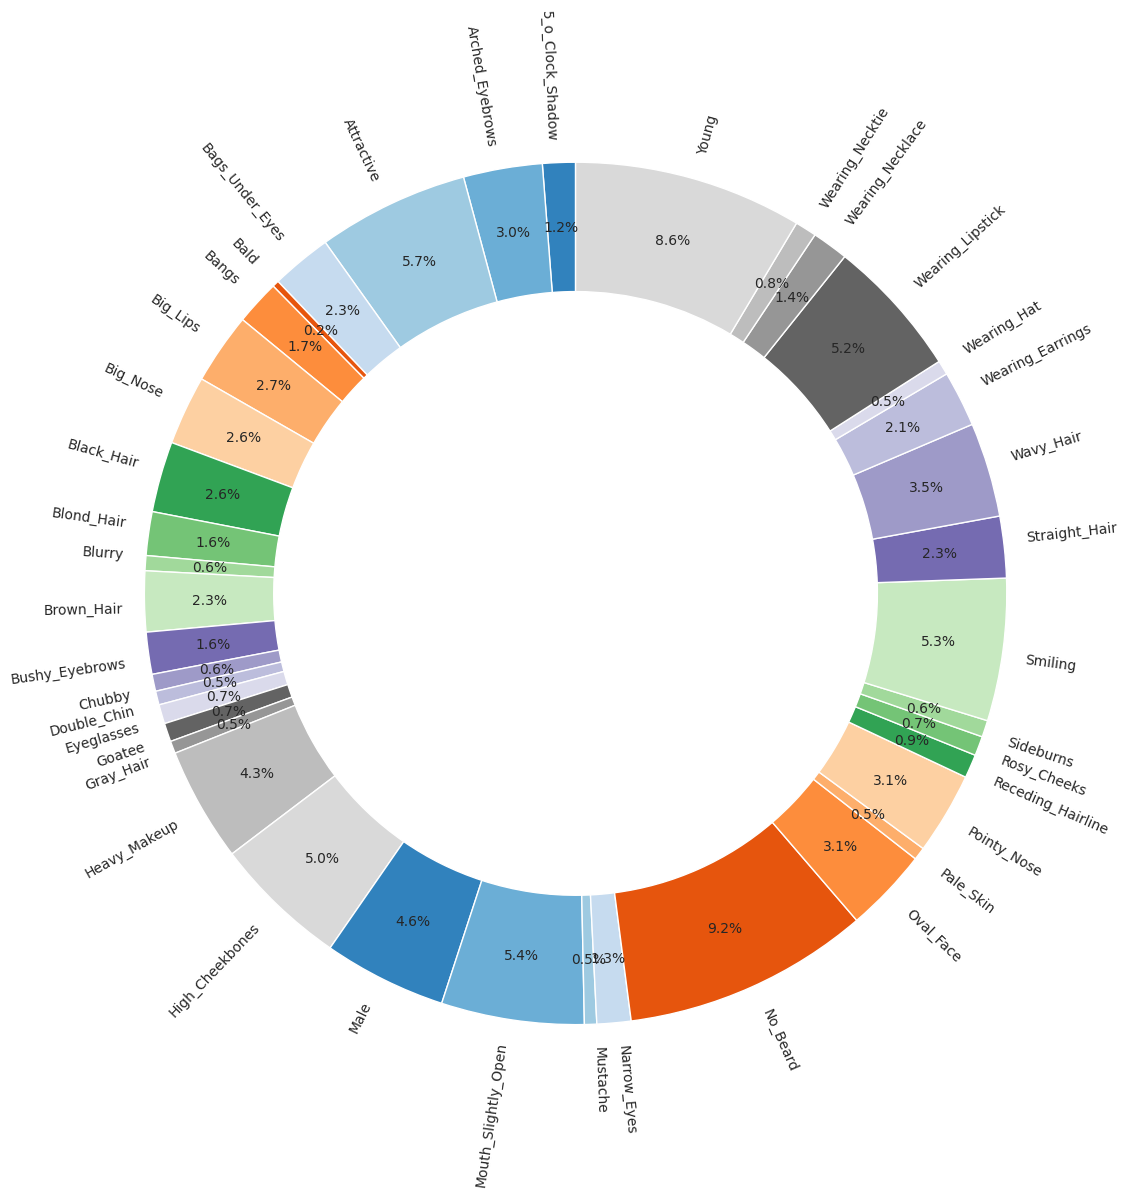

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df_attr là DataFrame của bạn
arr = pd.DataFrame(df_attr.iloc[:, 1:].sum(axis=0))
arr.columns = ['labels']

# Tính tỉ lệ phần trăm của mỗi đặc tính
feature_percentages = (arr['labels'] / len(df_attr)) * 100

# Chọn một bảng màu đa dạng (nên chọn bảng màu phù hợp với số lượng đặc tính)
colors = plt.cm.tab20c.colors

# Vẽ biểu đồ tròn
plt.figure(figsize=(14, 14))
plt.pie(feature_percentages, labels=feature_percentages.index, autopct='%1.1f%%', startangle=90, colors=colors,
        labeldistance=1.05, textprops={'fontsize': 10}, pctdistance=0.85, wedgeprops=dict(width=0.3), rotatelabels=True)

plt.show()


In [ ]:
# Chia Dataset thành các tập train,test and valid
from sklearn.model_selection import train_test_split

# Chia df_attr thành 2 tập: tập train_df và tập test
# Trong đó 5% dataset để train, 1% để test, có trộn dữ liệu trước khi chia
train_df,test = train_test_split(df_attr,train_size=0.4,test_size=0.01,shuffle=True,random_state=212)
# Chia tập test thành valid_df của tập test
valid_df,test_df = train_test_split(test,test_size=0.4,random_state=212)
train_df.shape,valid_df.shape,test_df.shape

((81039, 41), (1215, 41), (811, 41))

# **2. Data Preprocessing**

**Data augmentation**

Các kỹ thuật tăng cường dữ liệu được sử dụng:

*   Thay đổi hình học: thay đổi kích thước hình ảnh, xoay dọc, xoay ngang

*   Thay đổi màu sắc: thay đổi độ sáng, độ tương phản, độ bão hòa màu.

*   Chuyển đổi hình ảnh thành tensor PyTorch thông qua hàm ```transforms.ToTensor()```. Hàm này chuyển đổi ảnh với dải điểm ảnh [0, 255] thành PyTorch FloatTensor dạng (C, H, W) với dải [0.0, 1.0].

*  Quá trình chuẩn hóa trong PyTorch được thực hiện bằng cách sử dụng `torchvision.transforms.Normalize()`. Hàm này chuẩn hóa hình ảnh tensor với độ lệch trung bình và độ lệch chuẩn.

```
Syntax: torchvision.transforms.Normalize()
Parameter:
*  mean: Chuỗi các giá trị trung bình cho mỗi kênh.
*  std: Chuỗi các độ lệch chuẩn cho mỗi kênh.
*  inplace:  Giá trị Boolean cho biết có thực hiện phép chuẩn hóa tại chỗ hay không
Returns: Ảnh tensor đã được chuẩn hóa.

```
*  Kỹ thuật chuẩn hóa
```
output[channel] = (input[channel] - mean[channel]) / std[channel]
```







In [ ]:
# Sử dụng Data augmentation cho tập train.
train_transform=transforms.Compose([transforms.Resize((224,224)), # Thay đổi kích thước hình ảnh thành 224x224 pixel.
                                    transforms.RandomVerticalFlip(p=0.5), # Lật hình ảnh theo chiều dọc
                                    transforms.RandomHorizontalFlip(p=0.5), # Lật hình ảnh theo chiều ngang
                                    transforms.ColorJitter(brightness=0.4,  #Áp dụng xáo trộn màu sắc cho hình ảnh, thay đổi độ sáng, độ tương phản, độ bão hòa và màu sắc.
                                                           contrast=0.4,
                                                           saturation=0.4,
                                                           hue=0.2),
                                    transforms.ToTensor(), # Chuyển đổi hình ảnh thành một tensor PyTorch.
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) # Chuẩn hóa tensor hình ảnh với các giá trị trung bình và độ lệch chuẩn

# Sử dụng Data augmentation cho tập test và validation.
valid_transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# **3. Methodology**
Classification là bài toán phân loại một ảnh thành một nhãn duy nhất. Tuy nhiên, trên thực tế, một ảnh có thể xuất hiện nhiều đối tượng khác nhau, tương ứng với nhiều nhãn. Điều này dẫn đến hạn chế của classification là chỉ có thể dự đoán một nhãn cho một ảnh.

Để giải quyết hạn chế này, **Multitask learning** cho phép học nhiều nhiệm vụ trên cùng một dữ liệu. Các nhiệm vụ này có thể bổ trợ cho nhau, giúp cải thiện độ chính xác của việc dự đoán.

# **3.1.  Architecture**
Bao gồm 2 phrases:
*   Phrase 1: Base network có tác dụng làm nhiệm vụ trích lọc đặc trưng (feature extractor) từ các Convolutional 2D Layers. Trong thuật toán multitask learning thì feature extractor sẽ tạo ra output là những đặc trưng chung cho toàn bộ các nhiệm vụ.
*   Phrase 2: Thực hiện nhiều nhiệm vụ phân loại. Các đặc trưng chung được trích suất từ phrase 1 sẽ được sử dụng làm đầu vào cho bài toán phân loại nhị phân (Binary Classification) khác nhau. Output của chúng ta sẽ bao gồm nhiều units (Multi-head) mà mỗi unit sẽ tính toán khả năng xảy ra của một nhiệm vụ phân loại nhị phân.

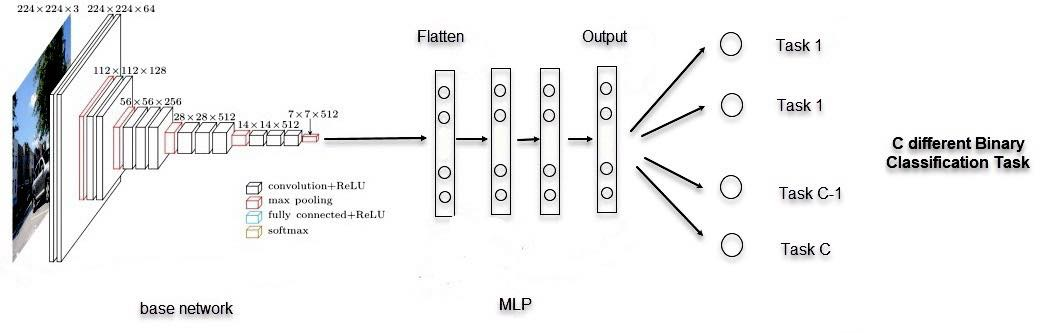
# **3.2. Multi-branch Architecture**
Kiến trúc rẽ nhánh sẽ cho phép thuật toán học được nhiều tác vụ đồng thời nhưng không chia sẻ đặc trưng. Mô hình của chúng ta sử dụng chung một đầu vào là ảnh và phân nhánh thành nhiều mô hình con. Mỗi mô hình sẽ phụ trách dự báo cho một tác vụ một cách độc lập.

Ví dụ: Trong nhận diện khuôn mặt, chúng ta sẽ cần sử dụng rất nhiều các dự báo trên cùng một ảnh khuôn mặt như: giới tính, độ tuổi, chủng tộc, màu mắt, màu tóc,….

# **3.3 Advantages and Disadvantages**

**3.3.1 Advantages**

*   Kiến trúc rẽ nhánh sẽ cho phép xây dựng được nhiều mô hình trên cùng một bộ dữ liệu.

*   Các mô hình là những tác vụ độc lập và không có các đặc trưng phân loại giống nhau.

*   Khi một tác vụ hoạt động không tốt thì cũng không ảnh hưởng tới những tác vụ khác vì mối quan hệ giữa các mô hình là độc lập.

*   Tiết kiệm tài nguyên và chi phí thời gian tính toán vì chúng ta huấn luyện các tác vụ đồng thời trên cùng một mô hình mà không cần huấn luyện lại từng mô hình đơn lẻ.

*   Kiến trúc rẽ nhánh đồng thời cũng kết hợp được giữa các bài toán classifcation và prediction với nhau trong cùng một kiến trúc mô hình.

*   Kiến trúc rẽ nhánh cho phép ta áp dụng được nhiều hàm loss function khác nhau trên các tác vụ huấn luyện khác nhau.

**3.3.2 Disadvantages**

*   Kiến trúc rẽ nhánh thường yêu cầu các mô hình phải có input image cùng một shape. Một số tác vụ dự báo chỉ cần một shape nhỏ hơn cũng đã cho kết quả tốt nên sẽ gây lãng phí tài nguyên tính toán nếu tất cả các mô hình sử dụng chung một high resolution image.

*   Loss function của kiến trúc rẽ nhánh rất đa dạng, trong đó một số tác vụ có thể có loss function đóng góp đa số vào loss function tổng quát cuối cùng. Do đó cần thiết lập trọng số cho loss function để cân bằng ảnh hưởng của chi phí mất mát giữa các tác vụ.

**3.4 Hàm loss function**
Trong thuật toán multitask learning, đối với mỗi một tác vụ phân loại sẽ có giá trị hàm loss function là:

${L}(\mathbf{y},\hat{\mathbf{y}}) = -\sum_{i = 1}^N (y_{i}.\log(\hat{y}_{i}) + (1-y_{i}).\log(1-\hat{y}_{i}))$

Khi có tác vụ phân loại khác nhau, hàm loss function gộp của chúng sẽ là:

${L}(\mathbf{y},\hat{\mathbf{y}}) = -\sum_{i = 1}^N\sum_{j=1}^{C}y_{ij}.\log(\hat{y}_{ij})+(1-y_{ij}).\log(1-\hat{y}_{ij})$

Trong đó $i$ là chỉ số của mẫu, $j$ là chỉ số của từng tác vụ.

Như vậy  hàm loss function của multitask learning là tổng các loss function (dạng binary cross entropy) của từng bài toán phân loại nhị phân ứng của mỗi một tác vụ.

# **4. Creating and training model**

**DataLoader**



In [ ]:
# Class to get data in specific format and preprocessing.
class CelebDataset(Dataset):
    def __init__(self,df_1,image_path,transform=None,mode='train'):
        super().__init__()
        self.attr = df_1.drop(['image_id'],axis=1) # Lưu trữ các thuộc tính (không bao gồm cột 'image_id') từ DataFrame đầu vào.
        self.path = image_path # Lưu trữ đường dẫn đến thư mục hình ảnh.
        self.image_id = df_1['image_id'] # Chứa các ID hình ảnh từ DataFrame đầu vào.
        self.transform = transform # Lưu trữ biến đổi hình ảnh sẽ được áp dụng.
        self.mode = mode # Chỉ định chế độ của tập dữ liệu('train').
    def __len__(self):
        # Trả về số lượng mẫu trong tập dữ liệu, bằng với số lượng ID hình ảnh trong cột 'image_id'
        return self.image_id.shape[0]
    def __getitem__(self,idx:int):
        image_name = self.image_id.iloc[idx] # Lấy tên hình ảnh dựa trên ID của hình (image_id)
        image = Image.open(os.path.join(image_path,image_name)) # Mở hình ảnh tương ứng
        attributes = np.asarray(self.attr.iloc[idx].T,dtype=np.float32)
        if self.transform:
            image = self.transform(image)
        return image,attributes # Trả về một bộ chứa hình ảnh và các thuộc tính của nó

In [ ]:
# Create Dataset Object and DataLoader for train and validation set

train_data = CelebDataset(train_df,image_path,train_transform)
train_loader = DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)

valid_data = CelebDataset(valid_df,image_path,valid_transform)
valid_loader = DataLoader(valid_data,batch_size=64,num_workers=2)

test_data=CelebDataset(test_df,image_path,valid_transform)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False,num_workers = 2)

**Visualizing Data**

In [ ]:
# function to visualize dataset
def imshow(images,attr,idx:int):
    # Chuyển đổi tensor PyTorch images thành một mảng NumPy, di chuyển nó sang CPU (nếu nó ở trên GPU) và
    # Chuyển vị các chiều để thay đổi thứ tự từ (kích_thước_loạt, kênh, chiều_cao, chiều_rộng) thành (kích_thước_loạt, chiều_cao, chiều_rộng, kênh).
    images=images.cpu().numpy().transpose((0,2,3,1))
    # Lấy hình ảnh tại vị trí 'idx'. Các giá trị pixel được nhân với độ lệch chuẩn và cộng với giá trị trung bình.
    # Bước này có khả năng đảo ngược quá trình chuẩn hóa đã được áp dụng cho các hình ảnh trong quá trình tiền xử lý.
    plt.imshow(images[idx]*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    # Tạo danh sách các nhãn thuộc tính có giá trị thuộc tính tương ứng bằng 1 (chỉ xét những thuộc tính có giá trị = 1, binary classification).
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()

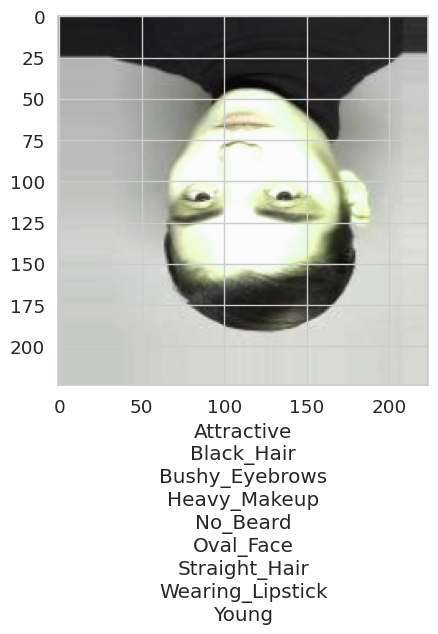

In [ ]:
# Visualizing Data
images,attr=next(iter(train_loader))
imshow(images,attr,0)

**Creating Model**
Class layer có cấu trúc gồm 3 lớp:

## Conv2d

$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k=0}^{C_{\text{in}}-1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$

Trong đó:

- out($N_i$, $C_{out_j}$) là giá trị đầu ra tại vị trí ($N_i$, $C_{out_j}$).
- bias($C_{out_j}$) là tham số bias tương ứng với kênh đầu ra thứ j.
- weight($C_{out_j}$, k) là ma trận trọng số tương ứng với kênh đầu ra $C_{out_j}$ và kênh đầu vào k.
- input($N_i$, k) là giá trị đầu vào tại vị trí ($N_i$, k).
- $*$ là toán tử tích chập 2D, được sử dụng để tính toán giá trị đầu ra.


Công thức này mô tả cách tính toán giá trị đầu ra của một lớp tích chập 2D dựa trên đầu vào và các trọng số của lớp.


\\
Về kích thước của kết quả:

$$
\text{Input}: (N, C_{\text{in}}, H_{\text{in}}, W_{\text{in}}) \text{ or } (C_{\text{in}}, H_{\text{in}}, W_{\text{in}})
$$

$$
\text{Output}: (N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}}) \text{ or } (C_{\text{out}}, H_{\text{out}}, W_{\text{out}})
$$

$$
\text{where}
$$

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1 \right\rfloor
$$

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1 \right\rfloor
$$


## BatchNorm2D

Dưới đây là cách viết lại mô tả của bạn trong định dạng LaTeX để hiển thị đúng trong Colab:

Batch Normalization được áp dụng trên đầu vào 4D (một mini-batch của đầu vào 2D với chiều kênh bổ sung) như mô tả trong bài báo "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift".

$$
y = \frac{x - E[x]}{\sqrt{Var[x]+\epsilon}} \cdot \gamma + \beta
$$

Trong đó, $E[x]$ và $Var[x]$ được tính toán theo từng chiều trên các mini-batch, và $\gamma$ và $\beta$ là các vector tham số có thể học được có kích thước C (trong đó C là kích thước đầu vào). Mặc định, các phần tử của $\gamma$ được đặt thành 1 và các phần tử của $\beta$ được đặt thành 0. Trong quá trình huấn luyện ở bước tiến, độ lệch chuẩn được tính toán thông qua ước lượng có thiên hướng, tương đương với torch.var(input, unbiased=False). Tuy nhiên, giá trị được lưu trữ trong trung bình di động của độ lệch chuẩn được tính toán thông qua ước lượng không thiên hướng, tương đương với torch.var(input, unbiased=True).

Mặc định, trong quá trình huấn luyện, lớp này giữ các ước lượng chạy của trung bình và phương sai được tính toán của nó, sau đó được sử dụng để chuẩn hóa trong quá trình đánh giá. Các ước lượng chạy được giữ với momentum mặc định là 0.1.

Nếu track_running_stats được đặt thành False, lớp này sẽ không giữ các ước lượng chạy, và thống kê batch sẽ được sử dụng trong quá trình đánh giá cũng như trong quá trình huấn luyện.

$$
\text{Input}: (N, C, H, W)
$$

$$
\text{Output}: (N, C, H, W) \text{ (cùng kích thước với đầu vào)}
$$

## ReLU

Dưới đây là cách viết lại mô tả của bạn trong định dạng LaTeX để hiển thị đúng trong Colab:

ReLU (Rectified Linear Unit) được áp dụng element-wise như sau:

$$
\text{ReLU}(x) = \max(0, x)
$$

Trong đó, \(\max\) là hàm trả về giá trị lớn nhất giữa 0 và \(x\).

Tham số:

- inplace (bool): có thể thực hiện phép tính trên chính dữ liệu đầu vào hay không. Mặc định: False

Kích thước:

Input: bất kỳ số chiều nào.

Output: cùng kích thước với đầu vào.






## Xavier Uniform


$$
\begin{array}{|c|c|}
\hline
\text{Nonlinearity} & \text{Gain} \\
\hline
\text{Linear/Identity} & 1 \\
\text{Conv}1\text{D/2D/3D} & 1 \\
\text{Sigmoid} & 1 \\
\text{Tanh} & \frac{5}{3}\\
\text{ReLU} & \sqrt{2} \\
\text{SELU} & \frac{3}{4} \\
\hline
\end{array}
$$


Phương pháp này được mô tả trong bài báo "Understanding the difficulty of training deep feedforward neural networks" của Glorot, X. & Bengio, Y. (2010). Kết quả tensor sẽ có các giá trị được lấy mẫu từ phân phối \(N(0, \text{std}^2)\) trong đó:

$$
\text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}
$$

Đây còn được gọi là Glorot initialization.

Tham số:

- tensor (Tensor): một torch.Tensor có n chiều
- gain (float): một hệ số tỷ lệ tùy chọn
- generator (Optional[Generator]): torch Generator để lấy mẫu từ (mặc định: None)



In [ ]:
# Defining Class for Single Layer.
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
      """ in_ch: Số lượng kênh đầu vào input channels.
      out_ch: Số lượng kênh đầu ra output channels.
      kernel_size: Kích thước của hạt nhân tích chập convolutional kernel (mặc định 3x3).
      stride: Bước nhảy của phép toán tích chập convolution operation (mặc định 1).
      padding: Phần đệm được thêm vào (mặc định 1). """
      super(Layer,self).__init__()
      self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
      self.bn=nn.BatchNorm2d(out_ch) # Thêm một lớp chuẩn hóa theo loạt với số lượng tính năng bằng `out_ch`.
      self.relu=nn.ReLU() # Thêm một hàm kích hoạt đơn vị tuyến tính chỉnh lưu (ReLU).
      nn.init.xavier_uniform_(self.conv.weight) # Khởi tạo các trọng số của lớp tích chập bằng cách sử dụng khởi tạo Xavier/Glorot.

    def forward(self,Input):
        output=self.conv(Input) # Áp dụng phép toán tích chập cho đầu vào
        output=self.bn(output) # Áp dụng chuẩn hóa theo loạt cho đầu ra của phép tích chập.
        output=self.relu(output) # Áp dụng hàm kích hoạt ReLU cho đầu ra đã được chuẩn hóa theo loạt.
        return output

## Maxpool2D

Max pooling 2D được áp dụng trên một tín hiệu đầu vào gồm nhiều mặt phẳng đầu vào.

Trong trường hợp đơn giản nhất, giá trị đầu ra của lớp với kích thước đầu vào \((N, C, H, W)\), đầu ra $(N, C, H_{\text{out}}, W_{\text{out}})$ và kernel_size \((kH, kW)\) có thể được mô tả chính xác như sau:

$$
\text{out}(N_i, C_j, h, w) = \max_{m=0,\ldots,kH-1} \max_{n=0,\ldots,kW-1} \text{input}(N_i, C_j, \text{stride}[0]\times h+m, \text{stride}[1]\times w+n)
$$

Nếu padding không bằng không, thì đầu vào được tự động thêm padding âm vô cùng ở cả hai bên cho số lượng điểm padding. dilation điều khiển khoảng cách giữa các điểm nhân của kernel. Việc mô tả nó khó hơn, nhưng liên kết này có một hình ảnh minh họa rõ ràng về dilation.

Tham số:

- kernel_size (Union[int, Tuple[int, int]]): kích thước của cửa sổ để lấy giá trị lớn nhất
- stride (Union[int, Tuple[int, int]]): bước của cửa sổ. Giá trị mặc định là kernel_size
- padding (Union[int, Tuple[int, int]]): Padding âm vô cùng ẩn được thêm vào cả hai bên
- dilation (Union[int, Tuple[int, int]]): tham số điều khiển bước nhảy của các phần tử trong cửa sổ
- return_indices (bool): nếu True, sẽ trả về chỉ số lớn nhất cùng với các đầu ra. Hữu ích cho torch.nn.MaxUnpool2d sau này
- ceil_mode (bool): khi True, sẽ sử dụng ceil thay vì floor để tính toán hình dạng đầu ra

Kích thước:

Đầu vào: \((N, C, $H_{in}$, $W_{in}$)\) hoặc \((C, $H_{in}$, $W_{in}$)\)

Đầu ra: \((N, C, $H_{out}$, $W_{out}$)\) hoặc \((C, $H_{out}$, $W_{out}$)\), trong đó

$$
H_{out} = \left\lfloor \frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1 \right\rfloor
$$

$$
W_{out} = \left\lfloor \frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1 \right\rfloor
$$

Khi bạn chèn đoạn mã này vào một ô Markdown trong Colab, nó sẽ hiển thị thông tin về các tham số và kích thước một cách đúng đắn.


## Dropout

Trong quá trình huấn luyện, ngẫu nhiên đặt giá trị bằng không cho một số phần tử của tensor đầu vào với xác suất \(p\).

Các phần tử bằng không được chọn độc lập cho mỗi lần gọi tiến về phía trước và được lấy mẫu từ phân phối Bernoulli.

Mỗi kênh sẽ được đặt bằng không độc lập trong mỗi lần gọi tiến về phía trước.

Đây đã được chứng minh là một kỹ thuật hiệu quả cho việc chính quy hóa và ngăn chặn sự đồng tác động của các nơ-ron như mô tả trong bài báo "Improving neural networks by preventing co-adaptation of feature detectors".

Hơn nữa, các đầu ra được nhân với một hệ số $\frac{1}{(1-p)}$ trong quá trình huấn luyện. Điều này có nghĩa là trong quá trình đánh giá, mô-đun đơn giản là tính toán một hàm đồng nhất.

Tham số:

- \(p\) (float): xác suất một phần tử bị đặt bằng không. Mặc định: 0.5
- inplace (bool): Nếu được đặt là True, sẽ thực hiện phép tính này trong chính nó. Mặc định: False

Kích thước:

Đầu vào: Đầu vào có thể có bất kỳ hình dạng nào

Đầu ra: Đầu ra có cùng hình dạng như đầu vào

## Linear

Dưới đây là cách viết lại mô tả của bạn trong định dạng LaTeX để hiển thị đúng trong Colab:

Áp dụng một biến đổi tuyến tính cho dữ liệu đầu vào:
$$y = xA^T + b.$$

Mô-đun này hỗ trợ TensorFloat32.

Trên một số thiết bị ROCm, khi sử dụng đầu vào float16, mô-đun này sẽ sử dụng độ chính xác khác nhau cho quá trình tính toán ngược.

Tham số:

- in_features (int): kích thước của mỗi mẫu đầu vào
- out_features (int): kích thước của mỗi mẫu đầu ra
- bias (bool): Nếu được đặt là False, lớp sẽ không học một độ lệch cộng thêm. Mặc định: True

Kích thước:

Đầu vào: (\*, $\text{H}_{\text{in}}$), trong đó \(*\) có thể là bất kỳ số chiều nào bao gồm cả không và $\text{H}_{\text{in}} = \text{in_features}$.

Đầu ra: (\*, $\text{H}_{\text{out}}$), trong đó tất cả trừ chiều cuối cùng có cùng hình dạng như đầu vào và $\text{H}_{\text{out}} = \text{out_features}$.



In [ ]:
# Complete model
class CelebModel(nn.Module):
    def __init__(self,num_classes=40):
        super(CelebModel,self).__init__()

        self.unit1=Layer(in_ch=3,out_ch=32)
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)

        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)

        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)

        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)

        self.drop2=nn.Dropout(0.5)

        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)

        self.pool5=nn.AvgPool2d(kernel_size=2)

        self.drop3=nn.Dropout(0.5)

        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)

        self.fc=nn.Linear(in_features=512,out_features=num_classes)


    def forward(self,Input):

        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)

        return output

In [ ]:
# setting environment
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Creating Model Object,loss function,optimizer and scheduler
model=CelebModel().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.0001,momentum=0.95)
scheduler=optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=1,mode='exp_range')

Hàm ```Save_model``` được thiết kế để lưu điểm kiểm tra mô hình vào một tệp nếu độ chính xác hiện tại lớn hơn độ chính xác tốt nhất đã thấy trước đó.
Mô hình tốt nhất được lưu trữ dưới dạng bản sao sâu để tránh các vấn đề với các tham chiếu được chia sẻ đến các tham số mô hình.
Sau đó, hàm trả về độ chính xác tốt nhất đã cập nhật. Loại điểm kiểm tra này thường được sử dụng trong quá trình đào tạo để lưu mô hình định kỳ, đảm bảo rằng mô hình hoạt động tốt nhất được giữ lại để sử dụng sau này

**Training and Validating Model**

In [ ]:
# Creating a Checkpoint to Save model
def Save_model(model,cur_acc,best_acc,filename):
    """ `model`: Mô hình PyTorch sẽ được lưu.
        `cur_acc`: Độ chính xác hiện tại của mô hình.
        `best_acc`: Độ chính xác tốt nhất đã thấy trước đó.
        `filename`: Tên của tệp nơi điểm kiểm tra mô hình sẽ được lưu. """
    if cur_acc > best_acc: # Kiểm tra xem độ chính xác hiện tại có lớn hơn độ chính xác tốt nhất đã thấy trước đó hay không.
        best_acc = cur_acc # Nếu có, cập nhật biến `best_acc` thành độ chính xác hiện tại 'cur_acc'.
        best_model = copy.deepcopy(model) # Tạo ra một bản sao mới của mô hình với tập hợp các tham số riêng, cho phép mô hình đã lưu độc lập với các thay đổi tiếp theo đối với mô hình gốc.
        torch.save(best_model,filename) # Lưu điểm kiểm tra mô hình tốt nhất vào tệp được chỉ định bằng cách sử dụng hàm `torch.save` của PyTorch.
    return best_acc

In [ ]:
# Create validation loop
def val_model():
    model.eval() # Đặt mô hình ở chế độ đánh giá
    epoch_loss=0
    acc=0
    with torch.no_grad(): # Vô hiệu hóa tính toán gradient trong quá trình xác thực để giảm mức sử dụng bộ nhớ và tăng tốc quá trình
        val_pred=[]
        val_lbl=[]
        for images,attr in valid_loader:
            if torch.cuda.is_available(): # Di chuyển dữ liệu sang GPU, nếu có
                images=images.to(device)
                attr=attr.to(device)
            output=model(images)
            loss=criterion(output,attr) #  Tính toán tổn thất giữa các dự đoán của mô hình và các thuộc tính thực tế
            prediction=torch.round(torch.sigmoid(output)) # : Áp dụng ngưỡng (0,5) và làm tròn đầu ra để thu được các dự đoán nhị phân.
            epoch_loss+=loss.item()*images.size(0) # Cập nhật tổng tổn thất
            val_lbl.append(attr.detach().cpu()) # Thêm các nhãn thực (thực tế) vào danh sách val_lbl.
            val_pred.append(prediction.detach().cpu()) # Thêm các dự đoán của mô hình vào danh sách val_pred
        epoch_loss/=len(valid_data) # Tính toán tổn thất trung bình trên mỗi hình ảnh
        acc=f1_score(torch.cat(val_lbl,dim=0).numpy(),torch.cat(val_pred,dim=0).numpy(),average='samples') # Tính toán điểm F1 (một chỉ số phổ biến cho các nhiệm vụ phân loại nhị phân)
        return epoch_loss,acc

In [ ]:
# Create Training loop
def train_model(num_epochs,is_tunning = False ):
    history_cnn_acc = {"train_acc": [], "val_acc": []}
    history_cnn_loss = {"train_loss": [], "val_loss": []}
    train_loss=[]
    best_acc=0.0
    for i in range(num_epochs):
        epoch_loss=0
        acc=0
        j=0
        epoch_pred=[]
        epoch_lbl=[]
        model.train()
        for images,attr in tqdm(train_loader):
            j+=1
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,attr)
            loss.backward()
            optimizer.step()
            prediction=torch.round(torch.sigmoid(output))
            epoch_loss+=loss.item()*images.size(0)
            epoch_lbl.append(attr.detach().cpu())
            epoch_pred.append(prediction.detach().cpu())
            torch.cuda.empty_cache()
            if (j+1)%500==0:
                print(f'Loss #{(j+1)//500}:{loss.item()}')
            scheduler.step()
        epoch_loss/=len(train_data)
        acc=f1_score(torch.cat(epoch_lbl,dim=0).numpy(),torch.cat(epoch_pred,dim=0).numpy(),average='samples')
        train_loss.append(epoch_loss)
        val_loss,val_acc=val_model()
        if is_tunning == False:
          best_acc=Save_model(model,val_acc,best_acc,'model.pth')   # save model
        print(f'Epoch : {i+1} , Training loss:{epoch_loss} , Training f1_score:{acc} , Validation loss:{val_loss} , Validation f1_score:{val_acc}')
        history_cnn_acc["train_acc"].append(acc)
        history_cnn_loss["train_loss"].append(epoch_loss)
        history_cnn_acc["val_acc"].append(val_acc)
        history_cnn_loss["val_loss"].append(val_loss)
        gc.collect()
    return history_cnn_acc, history_cnn_loss


In [ ]:
# Training model
num_epochs = 10
if __name__=='__main__':
    history_cnn_acc, history_cnn_loss = train_model(num_epochs)

 39%|███▉      | 499/1267 [05:22<06:30,  1.96it/s]

Loss #1:0.30343273282051086


 79%|███████▉  | 999/1267 [10:21<02:48,  1.59it/s]

Loss #2:0.2938498258590698


100%|██████████| 1267/1267 [13:17<00:00,  1.59it/s]


Epoch : 1 , Training loss:0.3218245965392944 , Training f1_score:0.6104200066908272 , Validation loss:0.25663512621396856 , Validation f1_score:0.6904162722958699


 39%|███▉      | 499/1267 [05:07<08:14,  1.55it/s]

Loss #1:0.28526774048805237


 79%|███████▉  | 999/1267 [10:33<02:23,  1.87it/s]

Loss #2:0.23216509819030762


100%|██████████| 1267/1267 [13:26<00:00,  1.57it/s]


Epoch : 2 , Training loss:0.2564215046365372 , Training f1_score:0.7009850454703209 , Validation loss:0.23497139135751213 , Validation f1_score:0.7198365413425125


 39%|███▉      | 499/1267 [05:43<10:22,  1.23it/s]

Loss #1:0.25061360001564026


 79%|███████▉  | 999/1267 [11:04<03:05,  1.45it/s]

Loss #2:0.23203781247138977


100%|██████████| 1267/1267 [13:59<00:00,  1.51it/s]


Epoch : 3 , Training loss:0.23347496969987383 , Training f1_score:0.7301294895576218 , Validation loss:0.21339072076136192 , Validation f1_score:0.7519497756167038


 39%|███▉      | 499/1267 [05:13<07:14,  1.77it/s]

Loss #1:0.22619639337062836


 79%|███████▉  | 999/1267 [10:20<02:37,  1.70it/s]

Loss #2:0.22929738461971283


100%|██████████| 1267/1267 [13:01<00:00,  1.62it/s]


Epoch : 4 , Training loss:0.22449510549806556 , Training f1_score:0.741751396540354 , Validation loss:0.21735722633546273 , Validation f1_score:0.7532017464737111


 39%|███▉      | 499/1267 [04:57<09:23,  1.36it/s]

Loss #1:0.2227056473493576


 79%|███████▉  | 999/1267 [10:01<02:23,  1.86it/s]

Loss #2:0.20996394753456116


100%|██████████| 1267/1267 [12:45<00:00,  1.65it/s]


Epoch : 5 , Training loss:0.22864157924070874 , Training f1_score:0.7373388178994041 , Validation loss:0.2194481894680502 , Validation f1_score:0.7339643058757073


 39%|███▉      | 499/1267 [05:02<06:52,  1.86it/s]

Loss #1:0.23923173546791077


 79%|███████▉  | 999/1267 [10:04<02:44,  1.63it/s]

Loss #2:0.24000850319862366


100%|██████████| 1267/1267 [12:46<00:00,  1.65it/s]


Epoch : 6 , Training loss:0.22050857697868265 , Training f1_score:0.7483351668318513 , Validation loss:0.20344364070352702 , Validation f1_score:0.7689326506010303


 39%|███▉      | 499/1267 [05:03<07:02,  1.82it/s]

Loss #1:0.21775272488594055


 79%|███████▉  | 999/1267 [10:51<03:03,  1.46it/s]

Loss #2:0.22772572934627533


100%|██████████| 1267/1267 [13:57<00:00,  1.51it/s]


Epoch : 7 , Training loss:0.21245035428556255 , Training f1_score:0.7580673332083563 , Validation loss:0.21049115682335057 , Validation f1_score:0.7712675892887728


 39%|███▉      | 499/1267 [05:04<06:53,  1.86it/s]

Loss #1:0.20899228751659393


 79%|███████▉  | 999/1267 [10:03<03:28,  1.28it/s]

Loss #2:0.2070380300283432


100%|██████████| 1267/1267 [12:45<00:00,  1.65it/s]


Epoch : 8 , Training loss:0.21749461192463598 , Training f1_score:0.7522996550474241 , Validation loss:0.21677201886971792 , Validation f1_score:0.7501874335864653


 39%|███▉      | 499/1267 [05:03<08:36,  1.49it/s]

Loss #1:0.22710548341274261


 79%|███████▉  | 999/1267 [10:20<02:49,  1.58it/s]

Loss #2:0.1996956765651703


100%|██████████| 1267/1267 [13:01<00:00,  1.62it/s]


Epoch : 9 , Training loss:0.2143181282291658 , Training f1_score:0.7563545989607281 , Validation loss:0.19950869401050694 , Validation f1_score:0.7751407816578497


 39%|███▉      | 499/1267 [05:06<07:11,  1.78it/s]

Loss #1:0.20372329652309418


 79%|███████▉  | 999/1267 [10:13<02:34,  1.74it/s]

Loss #2:0.2041567862033844


100%|██████████| 1267/1267 [12:57<00:00,  1.63it/s]


Epoch : 10 , Training loss:0.20613463112121405 , Training f1_score:0.7662826612580145 , Validation loss:0.204804613891943 , Validation f1_score:0.7726326556531131


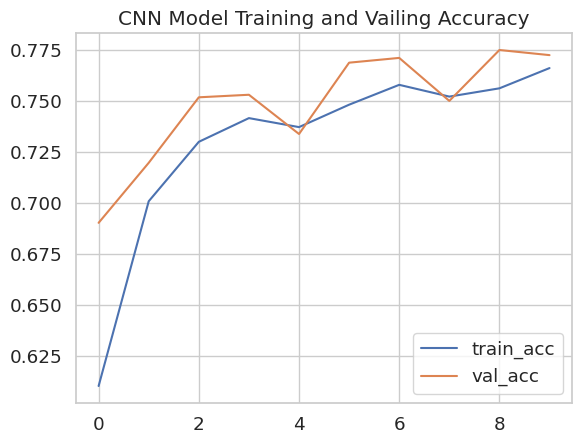

<Figure size 1800x400 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sử dụng thư viện pandas để tạo DataFrame từ dictionary
history_acc = pd.DataFrame(history_cnn_acc)

# Vẽ biểu đồ đường từ DataFrame
history_acc.plot.line()

# Thêm tiêu đề cho biểu đồ
plt.title('CNN Model Training and Vailing Accuracy')
plt.figure(figsize=(18, 4))
# Hiển thị biểu đồ
plt.show()

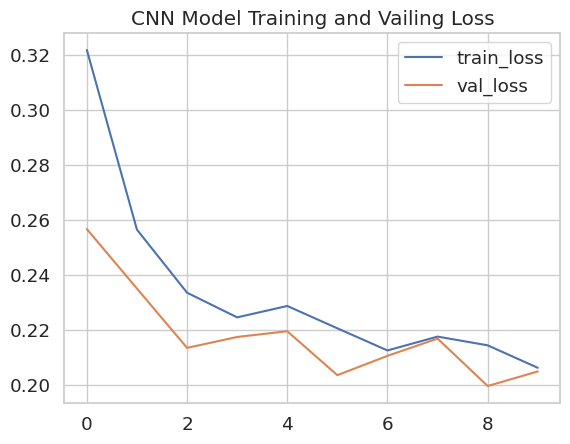

<Figure size 1800x400 with 0 Axes>

In [ ]:
# Sử dụng thư viện pandas để tạo DataFrame từ dictionary lịch sử đào tạo và kiểm tra
history_loss = pd.DataFrame(history_cnn_loss)

# Vẽ biểu đồ đường từ DataFrame
history_loss.plot.line()

# Thêm tiêu đề cho biểu đồ
plt.title('CNN Model Training and Vailing Loss')
plt.figure(figsize=(18, 4))
# Hiển thị biểu đồ
plt.show()

# **5. Tuning Hyperparameter**

In [ ]:
from sklearn.model_selection import ParameterGrid
import itertools

train_df,test = train_test_split(df_attr,train_size=0.05,test_size=0.01,shuffle=True,random_state=212)
valid_df,test_df = train_test_split(test,test_size=0.05,random_state=212)
train_df.shape,valid_df.shape,test_df.shape
train_transform=transforms.Compose([transforms.Resize((224,224)), # Thay đổi kích thước hình ảnh thành hình vuông với kích thước 224x224 pixel.
                                    transforms.RandomVerticalFlip(p=0.5), # Lật hình ảnh theo chiều dọc một cách ngẫu nhiên với xác suất 0,5.
                                    transforms.RandomHorizontalFlip(p=0.5), # Lật hình ảnh theo chiều ngang một cách ngẫu nhiên với xác suất 0,5.
                                    transforms.ColorJitter(brightness=0.4,  #Áp dụng xáo trộn màu sắc cho hình ảnh, thay đổi độ sáng, độ tương phản, độ bão hòa và màu sắc.
                                                           contrast=0.4,
                                                           saturation=0.4,
                                                           hue=0.2),
                                    transforms.ToTensor(), # Chuyển đổi hình ảnh thành một tensor PyTorch.
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) # Chuẩn hóa tensor hình ảnh với các giá trị trung bình và độ lệch chuẩn
valid_transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

train_data = CelebDataset(train_df,image_path,train_transform)
train_loader = DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
valid_data = CelebDataset(valid_df,image_path,valid_transform)
valid_loader = DataLoader(valid_data,batch_size=64,num_workers=2)

# Define the hyperparameter grid
param_grid = {
    'lr': [0.0001 ,0.000001],
    'momentum': [0.9, 0.95],
    'base_lr':[0.0001 ,0.0000001],
}

# Create all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Iterate over each combination
best_hyperparameters = None
best_performance = 0.0
best_model = None

# Iterate over each combination
for params in param_combinations:
    # Create the model with the specified hyperparameters
    model = CelebModel(num_classes=40).to(device)
    model.train()

    # Extract hyperparameters from the dictionary
    lr = params['lr']
    momentum = params['momentum']
    base_lr = params['base_lr']

    # Define optimizer and scheduler with current hyperparameters
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=1, mode='exp_range')

    # Train the model
    train_model(num_epochs=4, is_tunning =True)

    # Evaluate on validation set
    val_loss, val_acc = val_model()

    print(f"Hyperparameters: lr={lr}, momentum={momentum}, base_lr={base_lr}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
    if val_acc > best_performance:
        best_performance = val_acc
        best_hyperparameters = params

# Print and save the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

100%|██████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch : 1 , Training loss:0.45989805864833494 , Training f1_score:0.42635242490914005 , Validation loss:0.38799280572581935 , Validation f1_score:0.5503542157601652


100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch : 2 , Training loss:0.3577808161421629 , Training f1_score:0.5493075382542764 , Validation loss:0.3243232452448093 , Validation f1_score:0.5931578666197728


100%|██████████| 159/159 [01:36<00:00,  1.64it/s]


Epoch : 3 , Training loss:0.3209123244518847 , Training f1_score:0.6096821013607417 , Validation loss:0.3144398308717288 , Validation f1_score:0.6437100511510536


100%|██████████| 159/159 [01:38<00:00,  1.61it/s]


Epoch : 4 , Training loss:0.30084291895799453 , Training f1_score:0.6382517415921396 , Validation loss:0.2957816985813347 , Validation f1_score:0.6604669911220944
Hyperparameters: lr=0.0001, momentum=0.9, base_lr=0.0001
Validation Loss: 0.2957816985813347, Validation Accuracy: 0.6604669911220944


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 1 , Training loss:0.46013960380852664 , Training f1_score:0.43163844277479696 , Validation loss:0.38051888501569786 , Validation f1_score:0.495234351170133


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epoch : 2 , Training loss:0.351216335877554 , Training f1_score:0.5583285241043178 , Validation loss:0.3389992715167404 , Validation f1_score:0.5867956498354054


100%|██████████| 159/159 [01:36<00:00,  1.64it/s]


Epoch : 3 , Training loss:0.3153320859151504 , Training f1_score:0.6149973274665609 , Validation loss:0.31029534909928413 , Validation f1_score:0.613974952905465


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 4 , Training loss:0.2994222601182205 , Training f1_score:0.6394088663310274 , Validation loss:0.3004782675705432 , Validation f1_score:0.6549251887820724
Hyperparameters: lr=0.0001, momentum=0.95, base_lr=0.0001
Validation Loss: 0.3004782675705432, Validation Accuracy: 0.6549251887820724


100%|██████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch : 1 , Training loss:0.46529583041695477 , Training f1_score:0.4216031850164388 , Validation loss:0.3759349531914241 , Validation f1_score:0.546721639044984


100%|██████████| 159/159 [01:37<00:00,  1.63it/s]


Epoch : 2 , Training loss:0.3585460024444216 , Training f1_score:0.5509361509171149 , Validation loss:0.3355283055013034 , Validation f1_score:0.5950728143150479


100%|██████████| 159/159 [01:37<00:00,  1.63it/s]


Epoch : 3 , Training loss:0.3192893181028177 , Training f1_score:0.6114811545813161 , Validation loss:0.30418573911621266 , Validation f1_score:0.629356566217829


100%|██████████| 159/159 [01:36<00:00,  1.65it/s]


Epoch : 4 , Training loss:0.30132089478322976 , Training f1_score:0.6355688754903853 , Validation loss:0.28739172591984646 , Validation f1_score:0.6545940653162783
Hyperparameters: lr=1e-06, momentum=0.9, base_lr=0.0001
Validation Loss: 0.28739172591984646, Validation Accuracy: 0.6545940653162783


100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch : 1 , Training loss:0.46035696646576163 , Training f1_score:0.43087304777198004 , Validation loss:0.38307180306767724 , Validation f1_score:0.525865365834993


100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch : 2 , Training loss:0.3585551765460772 , Training f1_score:0.5475113655941817 , Validation loss:0.3583481580700547 , Validation f1_score:0.5615438359785662


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 3 , Training loss:0.3206278384702793 , Training f1_score:0.6081616082936849 , Validation loss:0.3398022424902093 , Validation f1_score:0.5936154229782759


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 4 , Training loss:0.3007777319166076 , Training f1_score:0.6360823167839093 , Validation loss:0.3144203698312914 , Validation f1_score:0.6423233717276245
Hyperparameters: lr=1e-06, momentum=0.95, base_lr=0.0001
Validation Loss: 0.3144203698312914, Validation Accuracy: 0.6423233717276245


100%|██████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch : 1 , Training loss:0.46257034433136357 , Training f1_score:0.4303220925754819 , Validation loss:0.3894382593165812 , Validation f1_score:0.552484417113019


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 2 , Training loss:0.35574054476456646 , Training f1_score:0.554159246687677 , Validation loss:0.3349689480048951 , Validation f1_score:0.5997097078176711


100%|██████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch : 3 , Training loss:0.3205994785991258 , Training f1_score:0.6101026036790376 , Validation loss:0.3027526492760236 , Validation f1_score:0.6429415877865363


100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch : 4 , Training loss:0.30303153599552557 , Training f1_score:0.6344792489478258 , Validation loss:0.31007584303679436 , Validation f1_score:0.6444388221051414
Hyperparameters: lr=0.0001, momentum=0.9, base_lr=1e-07
Validation Loss: 0.31007584303679436, Validation Accuracy: 0.6444388221051414


100%|██████████| 159/159 [01:36<00:00,  1.64it/s]


Epoch : 1 , Training loss:0.45982670831955696 , Training f1_score:0.42811102379727745 , Validation loss:0.3737147629508853 , Validation f1_score:0.5447049357161367


100%|██████████| 159/159 [01:36<00:00,  1.65it/s]


Epoch : 2 , Training loss:0.3570284991235391 , Training f1_score:0.5467378516030429 , Validation loss:0.34743868022103813 , Validation f1_score:0.5797592487519436


100%|██████████| 159/159 [01:38<00:00,  1.62it/s]


Epoch : 3 , Training loss:0.32246913467040594 , Training f1_score:0.6056266841598935 , Validation loss:0.31577702439748323 , Validation f1_score:0.6027716577967861


100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch : 4 , Training loss:0.30163714856641977 , Training f1_score:0.6360670354349565 , Validation loss:0.2897315213065633 , Validation f1_score:0.6505810582619341
Hyperparameters: lr=0.0001, momentum=0.95, base_lr=1e-07
Validation Loss: 0.2897315213065633, Validation Accuracy: 0.6505810582619341


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epoch : 1 , Training loss:0.46245465886558734 , Training f1_score:0.42806907267547983 , Validation loss:0.3752644561432503 , Validation f1_score:0.5079896636910082


100%|██████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch : 2 , Training loss:0.35250230971641044 , Training f1_score:0.5568466384778183 , Validation loss:0.33274322636657844 , Validation f1_score:0.5745813215351789


100%|██████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch : 3 , Training loss:0.3169239631191342 , Training f1_score:0.6128352407939335 , Validation loss:0.30531203740599744 , Validation f1_score:0.6267387065619366


100%|██████████| 159/159 [01:44<00:00,  1.52it/s]


Epoch : 4 , Training loss:0.30035820026978627 , Training f1_score:0.637923364489084 , Validation loss:0.2919860635874425 , Validation f1_score:0.6645821947788775
Hyperparameters: lr=1e-06, momentum=0.9, base_lr=1e-07
Validation Loss: 0.2919860635874425, Validation Accuracy: 0.6645821947788775


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epoch : 1 , Training loss:0.4611357471581355 , Training f1_score:0.42698438891553225 , Validation loss:0.38782973212660476 , Validation f1_score:0.5471464493099785


100%|██████████| 159/159 [01:32<00:00,  1.73it/s]


Epoch : 2 , Training loss:0.3566552923902353 , Training f1_score:0.550406636383088 , Validation loss:0.367535139629598 , Validation f1_score:0.5575573717438588


100%|██████████| 159/159 [01:32<00:00,  1.73it/s]


Epoch : 3 , Training loss:0.3221584638399178 , Training f1_score:0.6064350677641729 , Validation loss:0.30337527456253827 , Validation f1_score:0.6482697131896681


100%|██████████| 159/159 [01:32<00:00,  1.72it/s]


Epoch : 4 , Training loss:0.30358367019973537 , Training f1_score:0.6345154821314825 , Validation loss:0.300334067081959 , Validation f1_score:0.6391349333966955
Hyperparameters: lr=1e-06, momentum=0.95, base_lr=1e-07
Validation Loss: 0.300334067081959, Validation Accuracy: 0.6391349333966955
Best Hyperparameters: {'base_lr': 1e-07, 'lr': 1e-06, 'momentum': 0.9}


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchsummary import summary

model.to(DEVICE)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]             896
       BatchNorm2d-3         [-1, 32, 224, 224]              64
       BatchNorm2d-4         [-1, 32, 224, 224]              64
              ReLU-5         [-1, 32, 224, 224]               0
              ReLU-6         [-1, 32, 224, 224]               0
             Layer-7         [-1, 32, 224, 224]               0
             Layer-8         [-1, 32, 224, 224]               0
            Conv2d-9         [-1, 32, 224, 224]           9,248
           Conv2d-10         [-1, 32, 224, 224]           9,248
      BatchNorm2d-11         [-1, 32, 224, 224]              64
      BatchNorm2d-12         [-1, 32, 224, 224]              64
             ReLU-13         [-1, 32, 224, 224]               0
             ReLU-14         [-1, 32, 2

# **6. Predicting labels**

**Predict image in dataset**

Dự đoán ảnh từ tập dữ liệu

In [ ]:
# Function to predict Labels
def predictInCelebA(images,model,idx):
    # Dự đoán
    predicted_values = model(images)

    # Lấy danh sách nhãn từ dataframe
    attribute_labels = df_attr.columns.tolist()
    attribute_labels = attribute_labels[1:]

    # Tính toán giá trị dự đoán và chuyển đổi thành nhãn dự đoán
    predicted_attributes = torch.round(torch.sigmoid(predicted_values)).cpu().detach()

    # Lấy giá trị dự đoán và thuộc tính cụ thể theo chỉ số idx
    predicted_value_idx = torch.sigmoid(predicted_values[idx]).cpu().detach().numpy()
    attribute_idx = predicted_attributes[idx].numpy()

    # Lọc danh sách nhãn và giá trị dự đoán dựa trên điều kiện thuộc tính
    filtered_labels = [label for label, a in list(zip(attribute_labels, attribute_idx)) if a == 1]
    filtered_predictions = [p for p, a in list(zip(predicted_value_idx, attribute_idx)) if a == 1]

    images=images.cpu().numpy().transpose((0,2,3,1))
    fig = plt.figure(figsize=(15,10))
    plt.subplot(2,1, 1)
    plt.imshow(images[idx])
    plt.subplot(2,1,2)
    plt.barh(filtered_labels,filtered_predictions)
    plt.show()

In [ ]:
# Loading Save model
model=torch.load('model.pth',map_location=torch.device('cpu'))
model=model.eval()

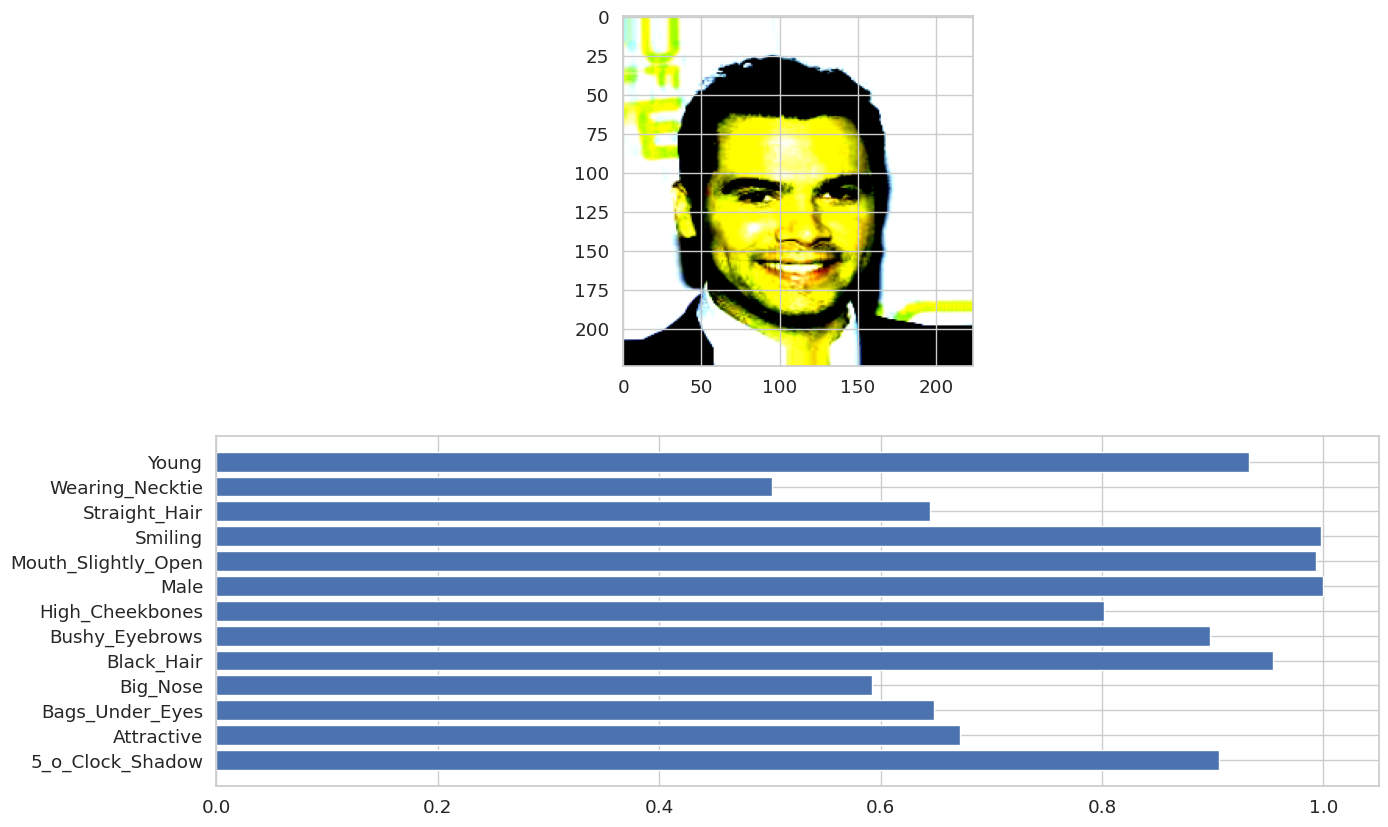

Predictions: None


In [ ]:
print('Predictions:',predictInCelebA(images,model,20))